# 0.0 Imports

In [129]:
import numpy as np
import math
import pandas as pd
import inflection
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import random
import pickle

from matplotlib.gridspec   import GridSpec 
from scipy                 import stats as ss
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

In [2]:
from IPython.display import Image

In [3]:
from IPython.core.display import HTML

## 0.1 Helper Functions

In [86]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,6)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat_m = m.predict(xvalidation)

        # performance
        m_result = ml_error('Linear Regression', np.expm1(yvalidation), np.expm1(yhat_m))

        # store performance for each kfold itaration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str)+' +/- '+np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str)+' +/- '+np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str)+' +/- '+np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container{width:100% !important;}</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [6]:
df_sales_raw = pd.read_csv('rossmann-store-sales/train.csv', low_memory=False)
df_store_raw = pd.read_csv('rossmann-store-sales/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Descrição dos dados

In [7]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [12]:
# #competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)



In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Stastistical

In [16]:
#separando as colunas numericas e categoricas em dataframes diferentes
num_attributes = df1.select_dtypes(include = ['float64', 'int64'])
cat_attributes = df1.select_dtypes(exclude = ['float64', 'int64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [17]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew e kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                  
# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


In [18]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


C:\Users\romul\Documents\dsprod\sales-pred\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

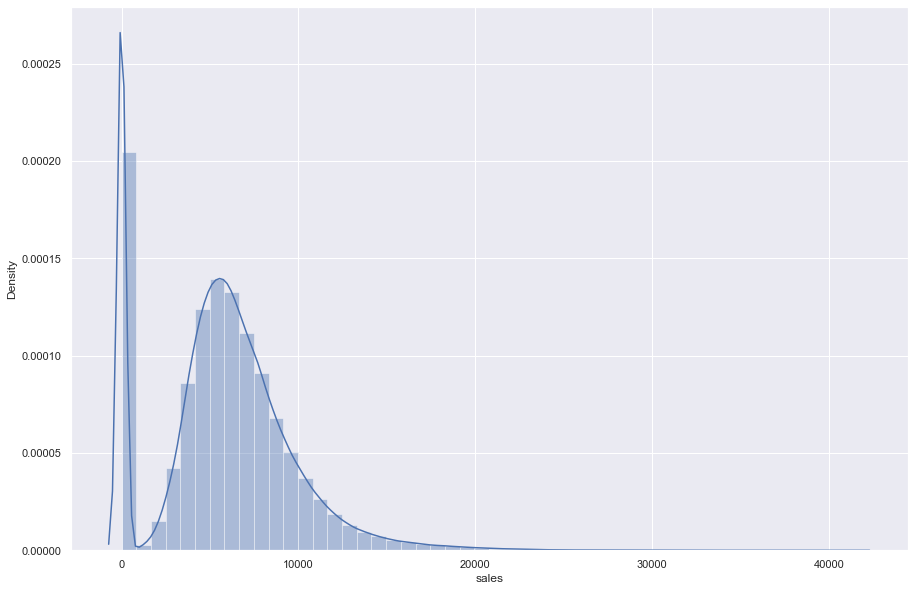

In [19]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.distplot(df1['sales'])

C:\Users\romul\Documents\dsprod\sales-pred\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

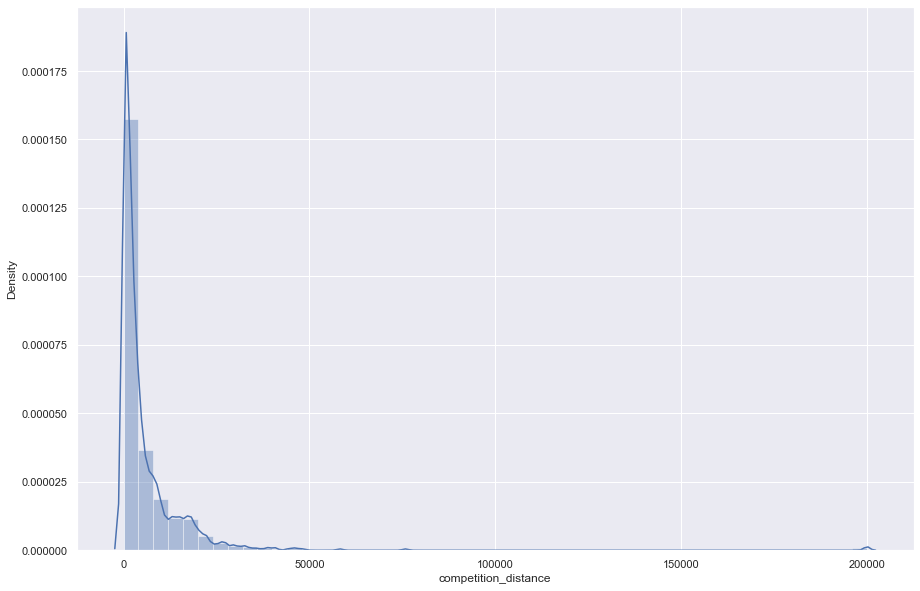

In [20]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [21]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

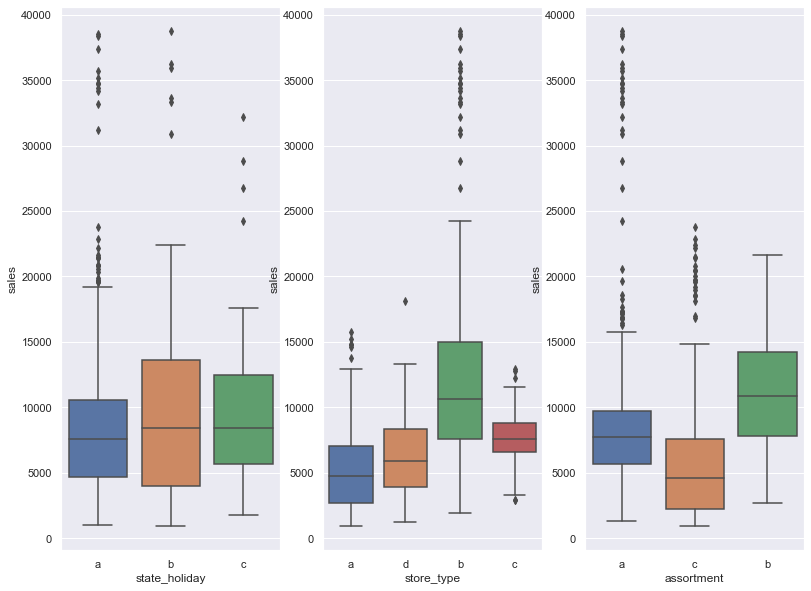

In [22]:
plt.rcParams['figure.figsize'] = (18, 10)
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.subplot(1, 4, 1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1, 4, 2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1, 4, 3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2.0 Feature Engineering

In [23]:
df2 = df1.copy()

In [24]:
Image('img/mindmaphypotesis.png')

FileNotFoundError: No such file or directory: 'img/mindmaphypotesis.png'

FileNotFoundError: No such file or directory: 'img/mindmaphypotesis.png'

<IPython.core.display.Image object>

## 2.1 Criação de hipóteses

### 2.1.1 Hipóteses Loja

**1.** Lojas com maior quantidade de funcionários deveria vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas que expoem mais o produto deveriam vender mais.

**3.** Lojas com menores preço deveriam vender mais.

**4.** Lojas com preços menores por mais tempo deveriam vender mais.

**5.** Lojas com promoções mais agressivas deveriam vender mais.

**6.** Lojas com promoções ativas pro mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoções deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais no segundo semestre do ano.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

**4.** Lojas deveriam vender mais ao longo dos anos

**5.** Lojas deveriam vender mais após o dia 10 de cada mês.

**6.** Lojas deveriam vender menos durante os feriados escolares.

**7.** Lojas deveriam vender masi ao longo dos anos.

## 2.2 Lista final de hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas pro mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoções deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas deveriam vender mais durante o feriado de natal.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais durante o segundo semestre do ano.

**10.** Lojas deveriam vender mais após o dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Feature Engineering

In [25]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x=='b' else 'extended')

# # state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public holiday' if x =='a' else 'Easter holiday' if x=='b' else 'Christmas' if x=='c' else 'regular_day')


C:\Users\romul\AppData\Local\Temp/ipykernel_18544/1051548726.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [26]:
df2.head(10).T

,0,1,2,3,4,5,6,7,8,9
store,1,2,3,4,5,6,7,8,9,10
day_of_week,5,5,5,5,5,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822,5651,15344,8492,8565,7185
customers,555,625,821,1498,559,589,1414,833,687,681
open,1,1,1,1,1,1,1,1,1,1
promo,1,1,1,1,1,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1,1,1,1,1,1
store_type,c,a,a,c,a,a,a,a,a,a


# 3.0 Filtragem de variáveis

In [27]:
df3 = df2.copy()

## 3.1 Filtragem de Linhas

In [28]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Filtragem de Colunas

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [30]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise Exploratória

In [31]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

C:\Users\romul\Documents\dsprod\sales-pred\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

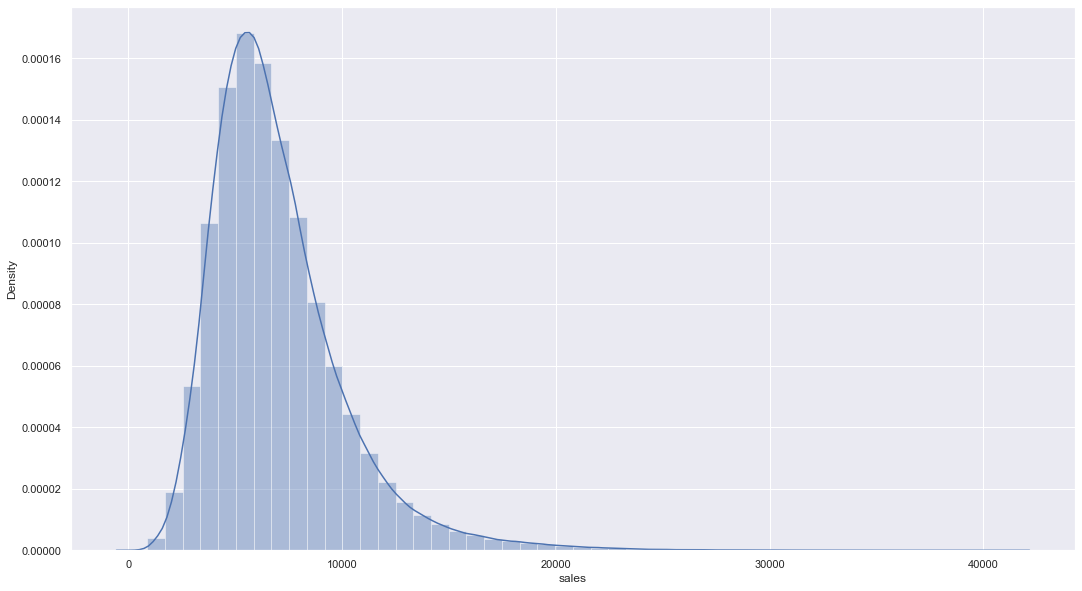

In [32]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical Variable

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>],
       [<AxesSubplot:title={'center':'customers'}>,
        <AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>],
       [<AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>,
        <AxesSubplot:title={'center':'promo2'}>],
       [<AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

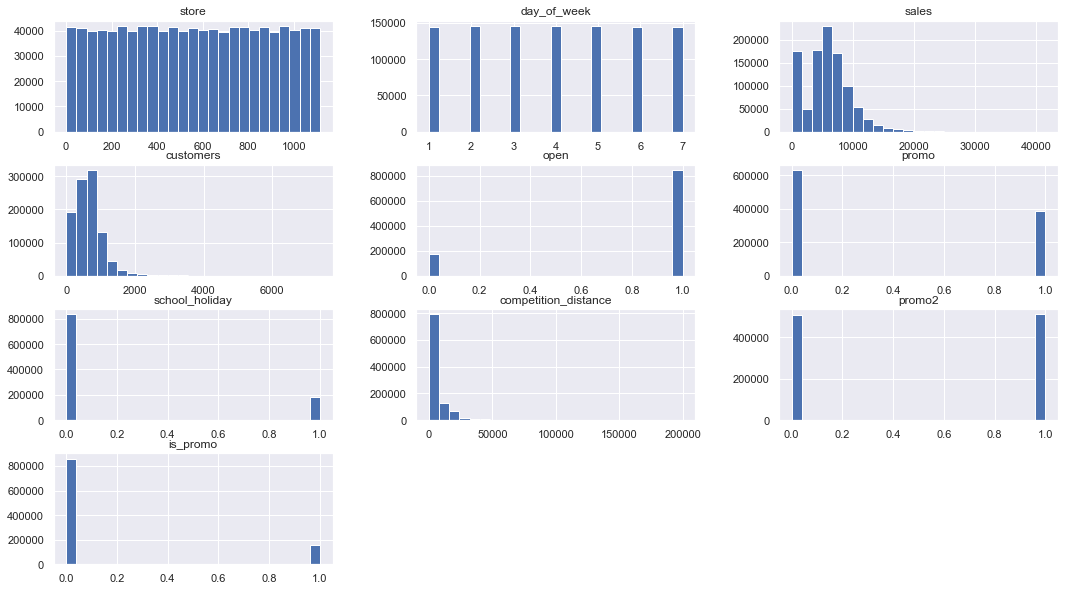

In [33]:
num_attributes.hist(bins=25)

### 4.1.3 Categorical Variable

In [34]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public holiday
129424    Easter holiday
241126         Christmas
Name: state_holiday, dtype: object

C:\Users\romul\Documents\dsprod\sales-pred\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\romul\Documents\dsprod\sales-pred\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\romul\Documents\dsprod\sales-pred\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

<AxesSubplot:xlabel='sales', ylabel='Density'>

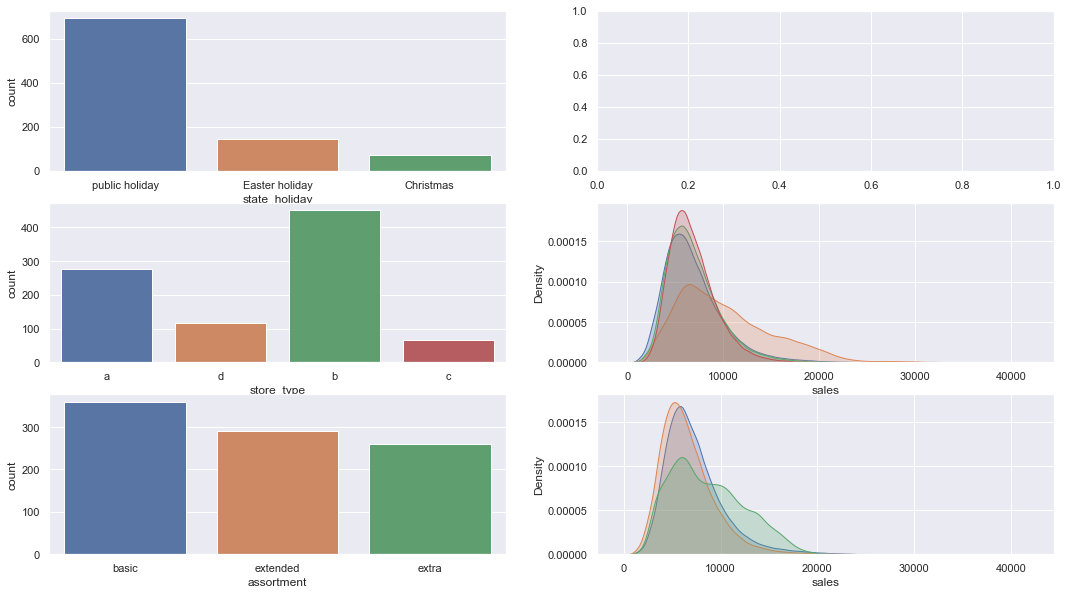

In [35]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas_holiday']['sales'], label='christmas_holiday', shade=True)

# store_types
plt.subplot(3, 2, 3)
sns.countplot(a['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)


# assortment
plt.subplot(3, 2, 5)
sns.countplot(a['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2 Análise Bivariada

#### **H1. Lojas com maior sortimento deveriam vender mais.**
**Falsa** Lojas com maior sortimento vendem menos

<AxesSubplot:xlabel='year_week'>

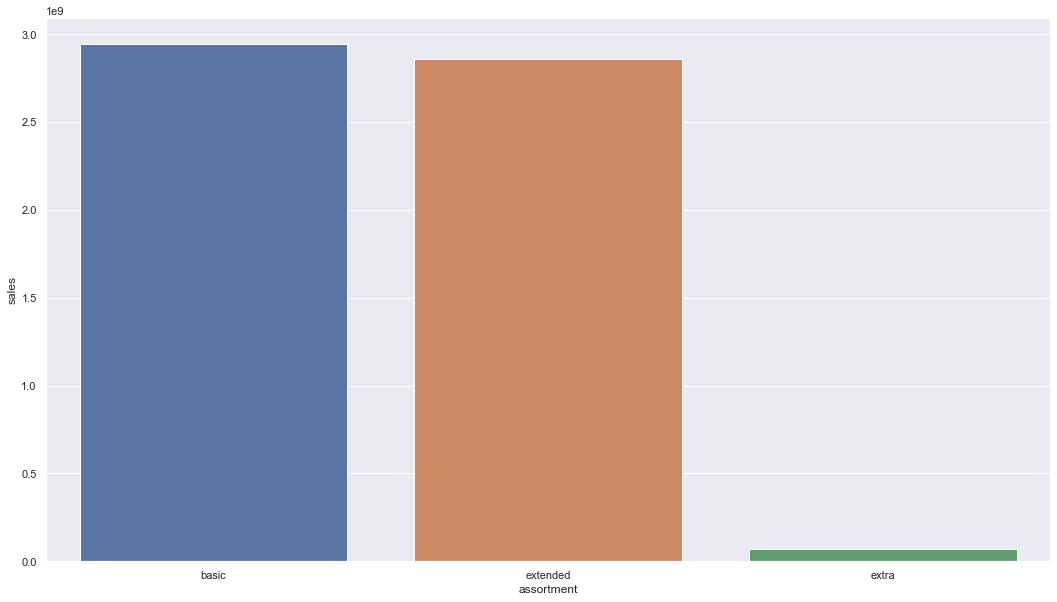

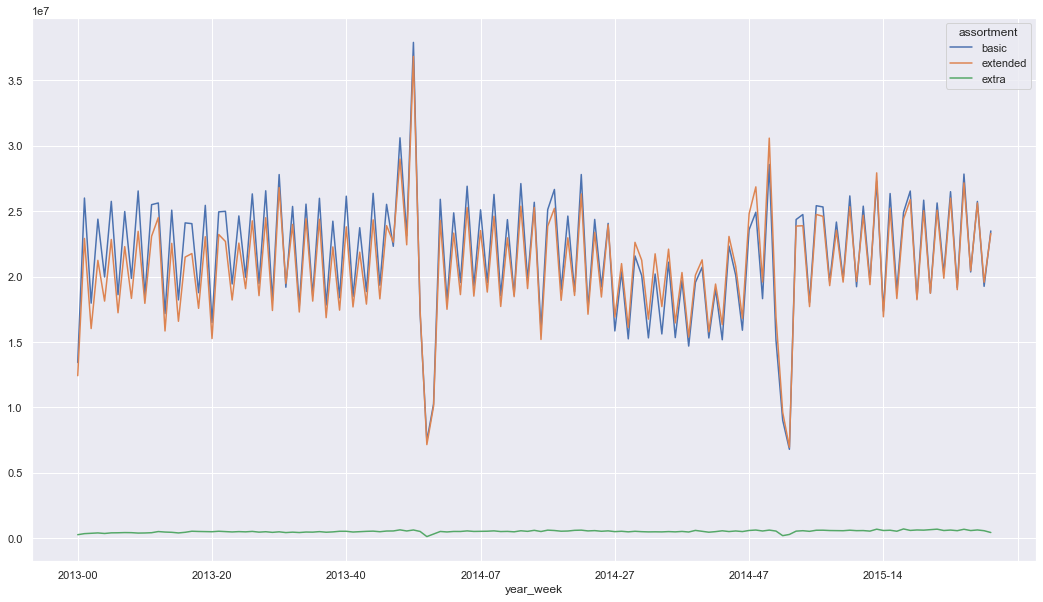

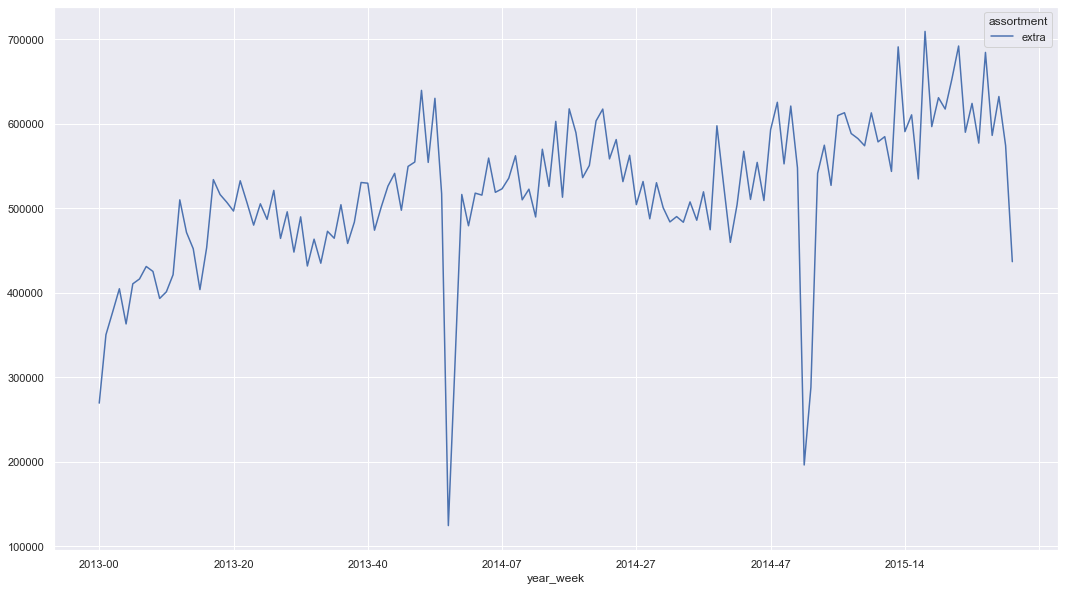

In [36]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

#### **H2. Lojas com competidores próximos deveriam vender menos.**
**Falsa** Lojas com competidores próximos vendem menos

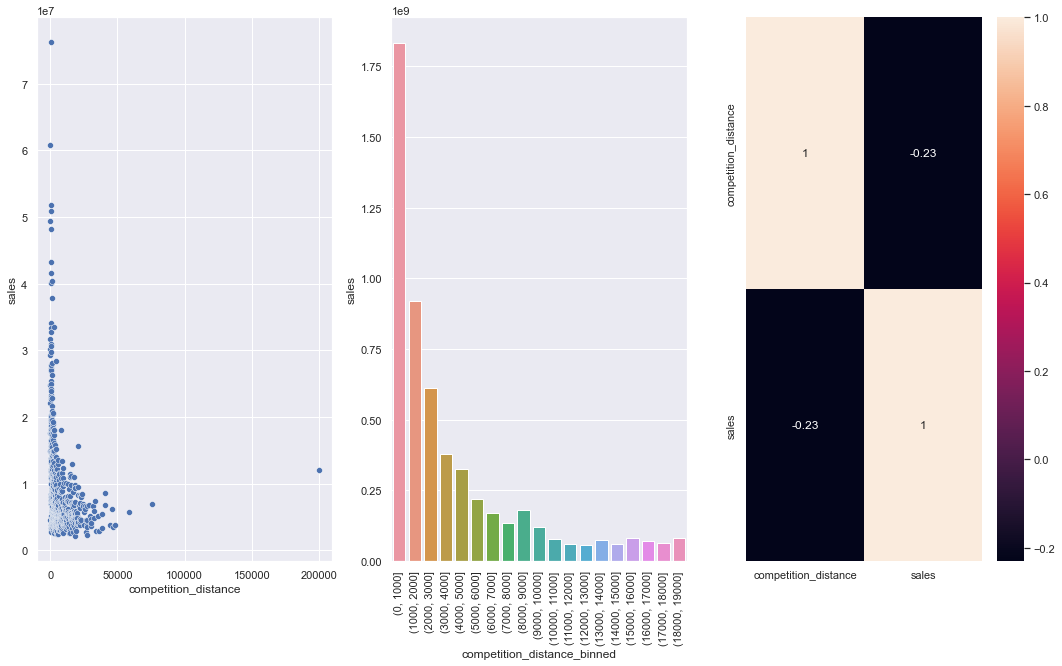

In [37]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


#### **H3. Lojas com competidores a mais tempo deveriam vender mais.**
**Falso** Lojas com competidores a mais tempo vendem menos.

In [38]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

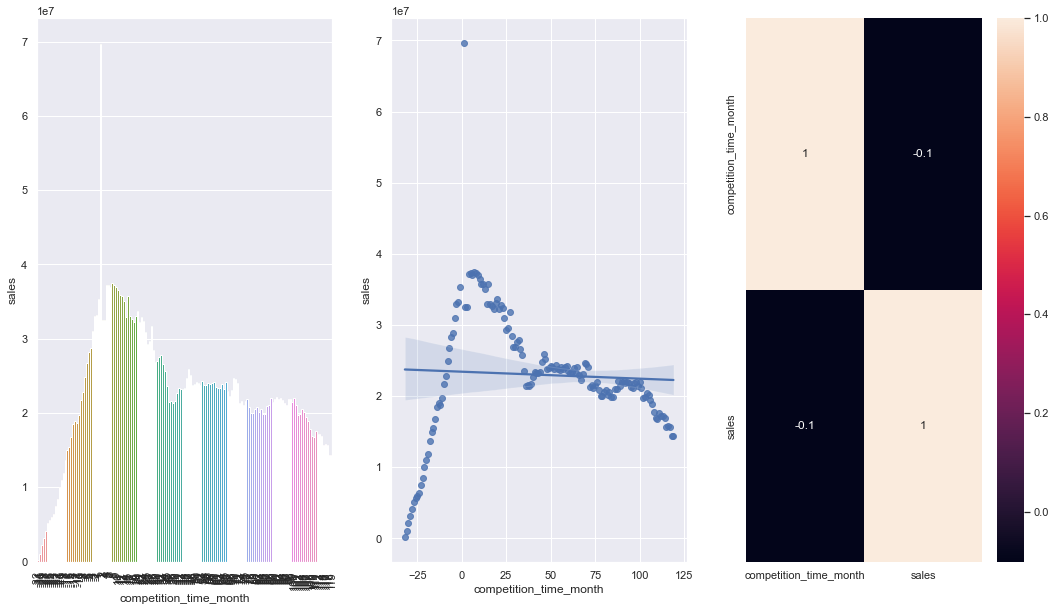

In [39]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);


plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H4. Lojas com promoções ativas pro mais tempo deveriam vender mais.
**Falsa** Lojas com promoções ativas a mais tempo vendem menos depois de um tempo.

In [40]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

<AxesSubplot:>

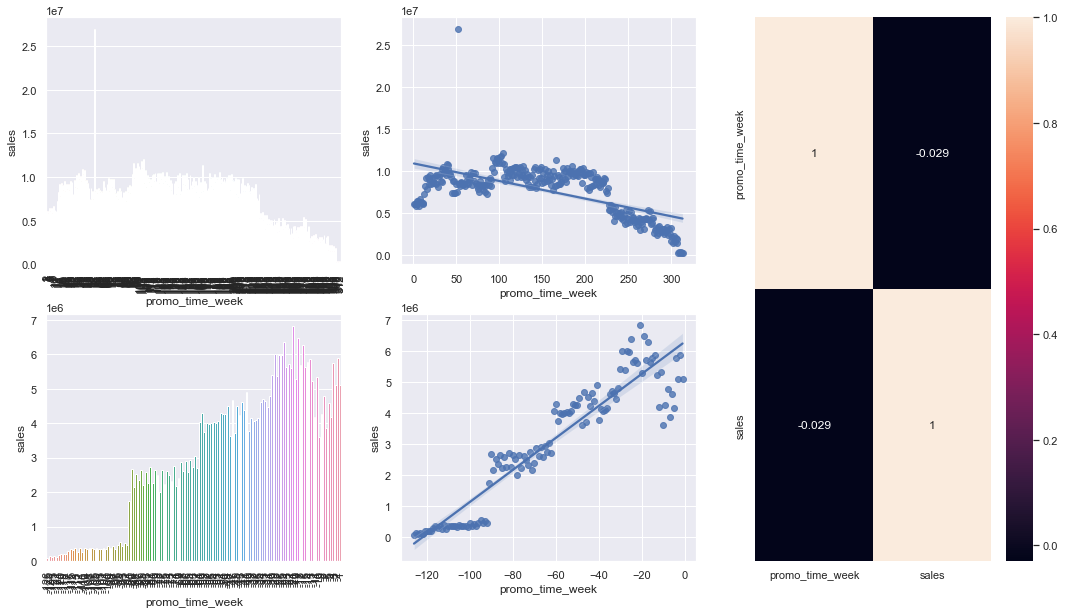

In [41]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extended
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### <s>H5. Lojas com mais dias de promoções deveriam vender mais.</s>

#### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**Falso** Lojas com promoções consecutivas vendem menos.

In [42]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


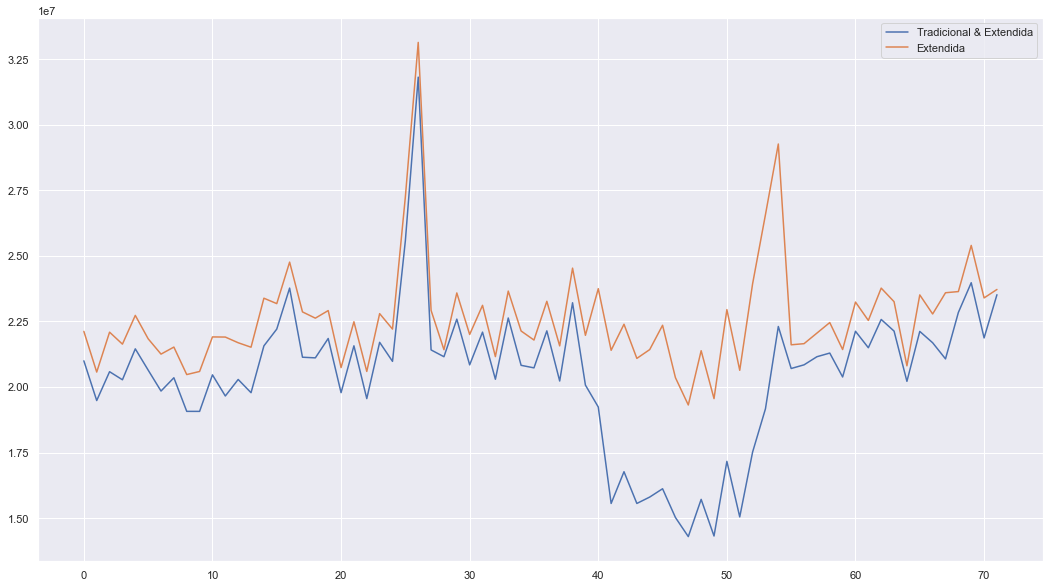

In [43]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['Tradicional & Extendida', 'Extendida'])

#### H7. Lojas deveriam vender mais durante o feriado de natal.
**Falsa** Lojas vendem menos durante o feriado de Natal

In [44]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

<AxesSubplot:xlabel='year', ylabel='sales'>

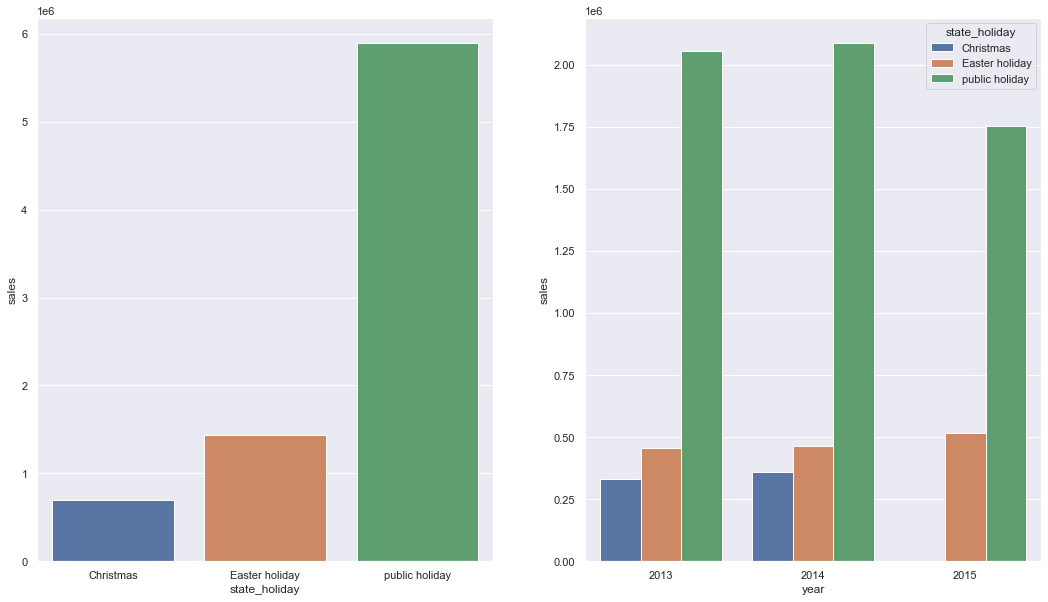

In [45]:
aux = df4[(df4['state_holiday'] != 'regular_day')]

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday','sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales', hue='state_holiday', data=aux2)

#### H8. Lojas deveriam vender mais ao longo dos anos.
**Falso** Lojas vendem menos ao longo dos anos

<AxesSubplot:>

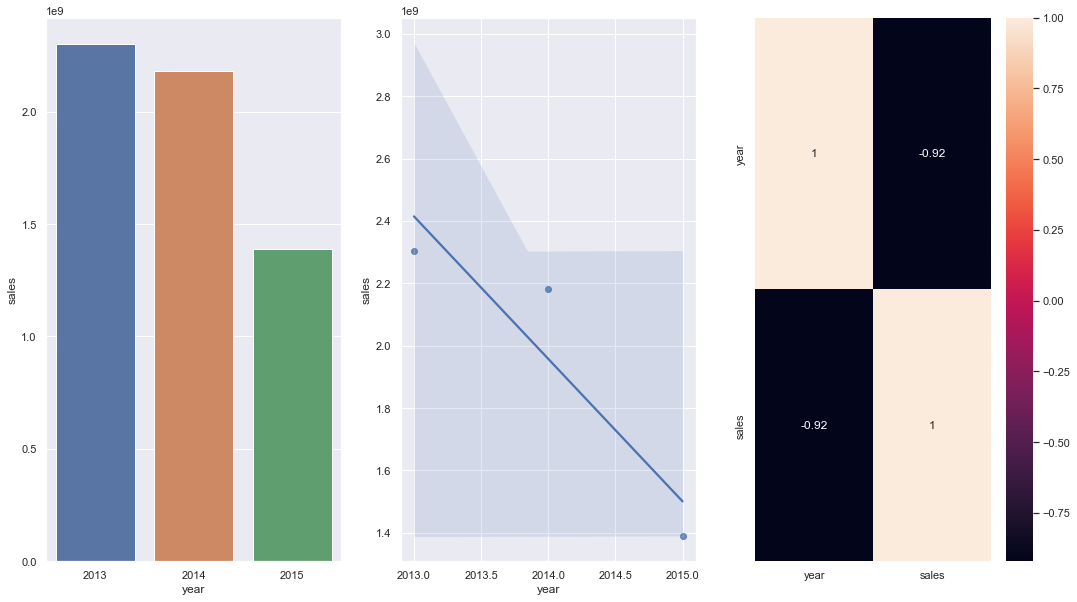

In [46]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### H9. Lojas deveriam vender mais durante o segundo semestre do ano.
**Falso** Lojas vendem menos no segundo semestre do ano

<AxesSubplot:>

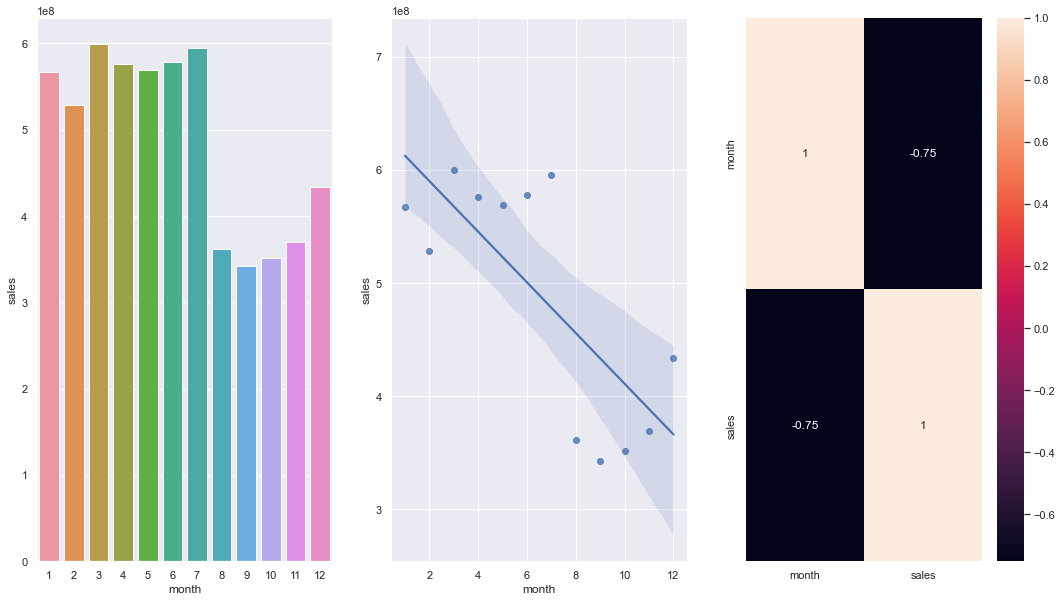

In [47]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### H10. Lojas deveriam vender mais após o dia 10 de cada mês.
**Verdadeiro** Lojas vendem mais após o dia 10 do mês.

<AxesSubplot:xlabel='before_after', ylabel='sales'>

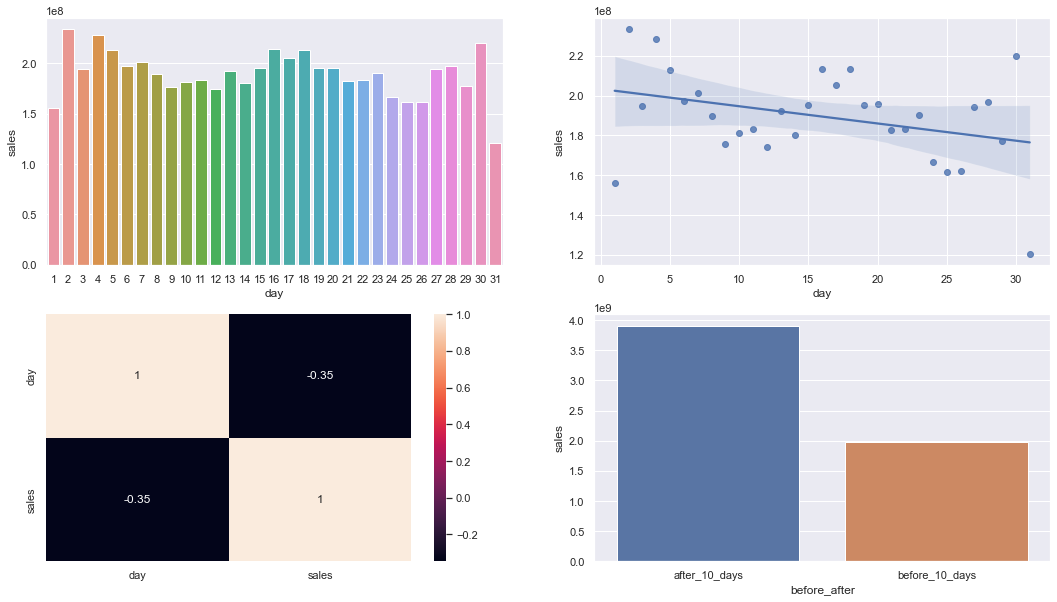

In [48]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2)

#### H11. Lojas deveriam vender menos aos finais de semana
**Verdadeira** Lojas vendem menos aos finais de semana

<AxesSubplot:>

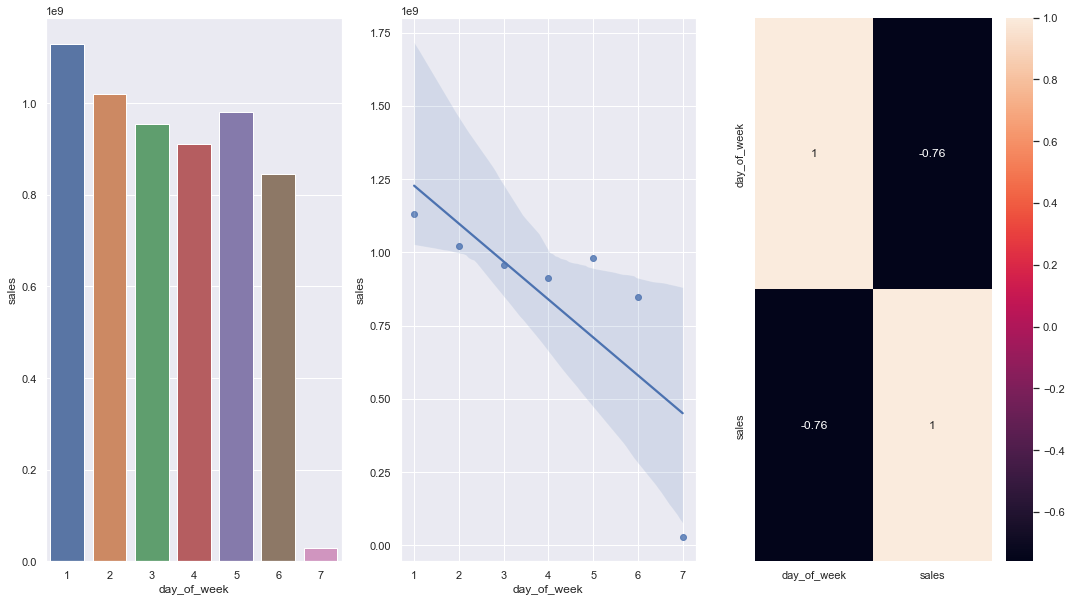

In [49]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### H12. Lojas deveriam vender menos durante os feriados escolares.
**Verdadeiro** Lojas vendem menos durante os feriados escolares

<AxesSubplot:xlabel='month', ylabel='sales'>

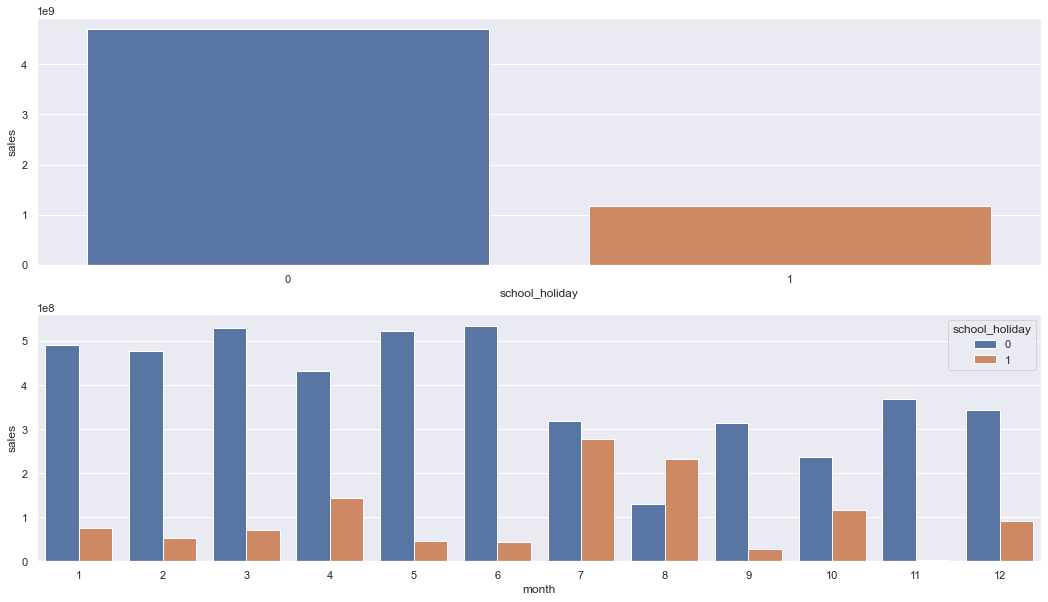

In [50]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales', hue='school_holiday',data=aux2)

## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot:>

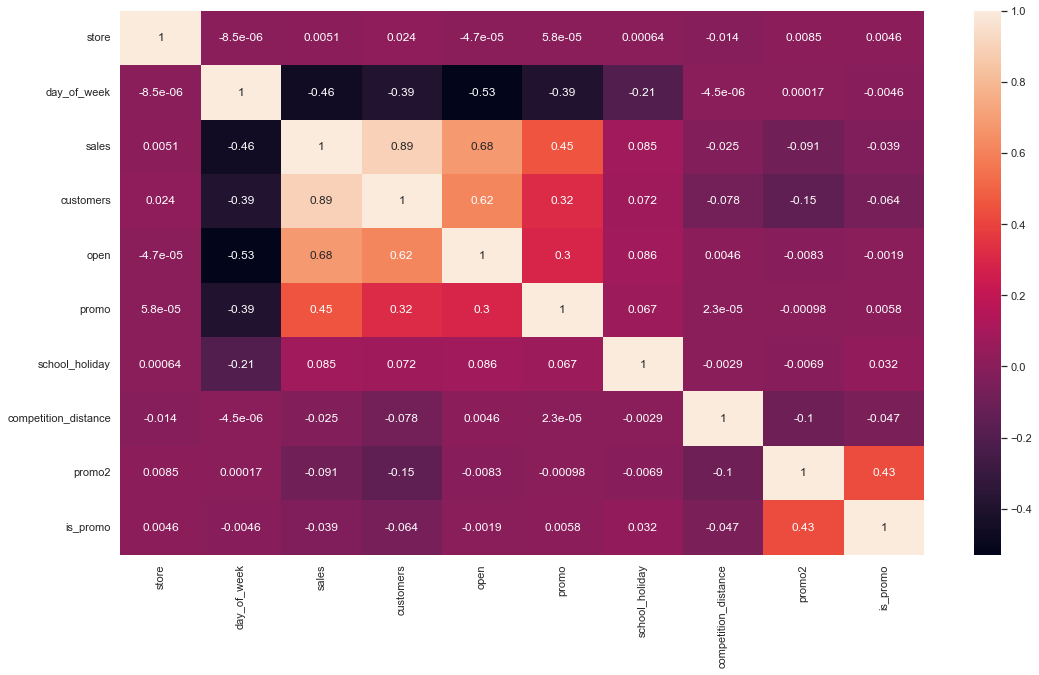

In [51]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

In [52]:
# only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramver_v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9]
                  } )

d = d.set_index(d.columns)

<AxesSubplot:>

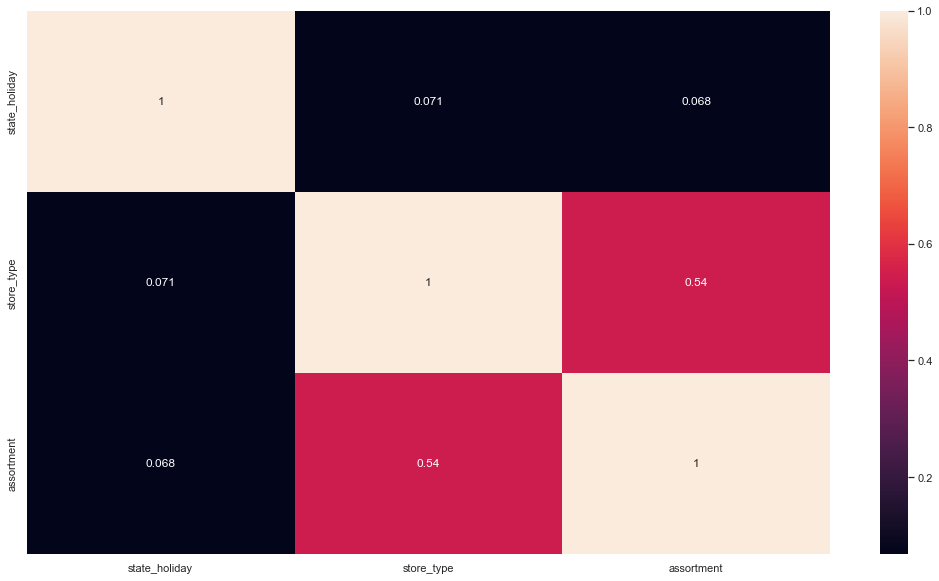

In [53]:
sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [54]:
df5 = df4.copy()

## 5.1 Normalizarion

## 5.2 Rescaling

In [55]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

## 5.3 Transformation

### 5.3.1 Enconding

In [56]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type - Label Enconding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [57]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transform

In [58]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

In [59]:
df5.sample(4)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_Christmas,state_holiday_Easter holiday,state_holiday_public holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
1000985,501,2,2013-01-15,8.547916,0,0,0,3,-0.114516,9,2006,0,3,2013,0,0.0,1,15,3,2013-02,2006-09-01,0.824324,2013-01-14,0.287016,0,0,0,1,5.000000e-01,0.866025,1.224647e-16,-1.000000,0.354605,0.935016,0.974928,-0.222521
749138,644,4,2013-08-29,9.126741,1,1,2,1,0.274194,12,2004,1,14,2011,0,0.0,8,29,35,2013-34,2004-12-01,1.216216,2011-03-28,0.574032,0,0,0,1,-8.660254e-01,-0.500000,-2.079117e-01,0.978148,-0.885456,-0.464723,-0.433884,-0.900969
841108,69,5,2013-06-07,9.287209,1,0,2,3,-0.193548,6,2013,1,40,2011,0,0.0,6,7,23,2013-22,2013-06-01,-0.216216,2011-09-26,0.487472,0,0,0,1,1.224647e-16,-1.000000,9.945219e-01,0.104528,0.354605,-0.935016,-0.974928,-0.222521
852098,1024,3,2013-05-29,8.724045,1,0,2,3,-0.054839,1,2012,0,22,2013,0,0.0,5,29,22,2013-21,2012-01-01,0.013514,2013-05-27,0.287016,0,0,0,1,5.000000e-01,-0.866025,-2.079117e-01,0.978148,0.464723,-0.885456,0.433884,-0.900969


# 6.0 Feature selection

In [60]:
df6 = df5.copy()

### 6.1 Split dataframe into trainging and test dataset

In [61]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [62]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [63]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] > '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-20 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 6.2 Borura as Feature Selector

In [64]:
#training and test dataset for boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [65]:
#cols_selected = boruta.support_.tolist() # valor do ranking

# best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

### 6.3 Manual Feature Selection

In [66]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Moddeling

In [67]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# variaveis relevantes com data e sales
x_training = X_train[cols_selected_boruta_full] 

## 7.1 Average Model

In [87]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Avarage Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1366.128351,0.452087,1854.263316


## 7.2 Linear Regression Model

In [88]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction 
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.73952,0.293745,2675.947846


### 7.2.1 Linear Regression Model - Cross Validation

In [99]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model

In [89]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction 
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1894.132074,0.290168,2750.81867


### 7.3.1 Linear Regression Regularized Model - Cross Validation

In [100]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [90]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction 
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.085648,0.099944,1010.932143


### 7.4.1 Random Forest Regressor - Cross Validation

In [91]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,837.68 +/- 218.12,0.12 +/- 0.02,1256.33 +/- 318.28


## 7.5 XGBoost Regressor

In [94]:
# model
model_xgb = xgb.XGBRegressor().fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,868.407952,0.130204,1241.891209


### 7.5.1 XGBoost Regressor - Cross Validation

In [95]:
xgb_result_cv = cross_validation(x_training, 100, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1074.84 +/- 199.67,0.15 +/- 0.02,1540.63 +/- 278.07


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [96]:
moddeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
moddeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.085648,0.099944,1010.932143
0,XGBoost Regressor,868.407952,0.130204,1241.891209
0,Avarage Model,1366.128351,0.452087,1854.263316
0,Linear Regression,1868.739520,0.293745,2675.947846
0,Linear Regression - Lasso,1894.132074,0.290168,2750.818670


### 7.6.2 Real Performance - Cross Validation

In [104]:
moddeling_result = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
moddeling_result.sort_values('RMSE CV')

,Model name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,837.68 +/- 218.12,0.12 +/- 0.02,1256.33 +/- 318.28
0,XGBoost Regressor,1074.84 +/- 199.67,0.15 +/- 0.02,1540.63 +/- 278.07
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0 Hyperparameter Fine Tuning

**xgboost was chosen for the lowest cost compared to the Random Forest**

## 8.1 Random Search

In [105]:
'''
param = {
         'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 5
'''

In [106]:
'''
final_result = pd.DataFrame()

for i in range (MAX_EVAL):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print(hp)
    
    # model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytee=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])

    # performance
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
    final_result = pd.concat([final_result, result])

final_result
'''

{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}

KFold Number: 5
[21:26:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number: 4
[21:40:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.





KFold Number: 2
[11:37:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number: 1
[11:45:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}


,Model name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,831.61 +/- 132.53,0.12 +/- 0.01,1201.21 +/- 194.75
0,XGBoost Regressor,832.15 +/- 129.82,0.12 +/- 0.01,1203.02 +/- 196.39
0,XGBoost Regressor,923.89 +/- 111.87,0.13 +/- 0.01,1318.89 +/- 153.17
0,XGBoost Regressor,949.8 +/- 149.44,0.13 +/- 0.01,1368.7 +/- 204.97
0,XGBoost Regressor,1449.73 +/- 146.98,0.2 +/- 0.01,2088.14 +/- 179.78


## 8.2 Final Model

In [108]:
'''
param_tuned = {'n_estimators': 3000, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}

# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=param_tuned['n_estimators'],
                             eta=param_tuned['eta'],
                             max_depth=param_tuned['max_depth'],
                             subsample=param_tuned['subsample'],
                             colsample_bytee=param_tuned['colsample_bytree'],
                             min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned ))
xgb_result_tuned
'''

[12:23:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,666.505452,0.096956,978.003413


## 8.3 Saving Model

In [139]:
'''
model = open('model/model_rossman_xgb_v01.pkl', 'wb')
pickle.dump(model_xgb_tuned, model)
model.close()
'''

In [141]:
# how to open pickle
mo = open('model/model_rossman_xgb_v01.pkl','rb')
new_dict = pickle.load(mo)
mo.close()

# 9.0 Tradução e interpretação do erro

In [145]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

C:\Users\romul\AppData\Local\Temp/ipykernel_18544/1540074760.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
C:\Users\romul\AppData\Local\Temp/ipykernel_18544/1540074760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


## 9.1 Business Performance

In [162]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [168]:
# ordered for MAPE
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,99349.085938,95790.622654,102907.549221,3558.463284,0.606170
908,909,215897.578125,207821.423739,223973.732511,8076.154386,0.538381
594,595,344382.250000,339683.784465,349080.715535,4698.465535,0.320328
875,876,192623.953125,188516.526678,196731.379572,4107.426447,0.310170
273,274,191006.343750,189655.232776,192357.454724,1351.110974,0.233443


<AxesSubplot:xlabel='store', ylabel='MAPE'>

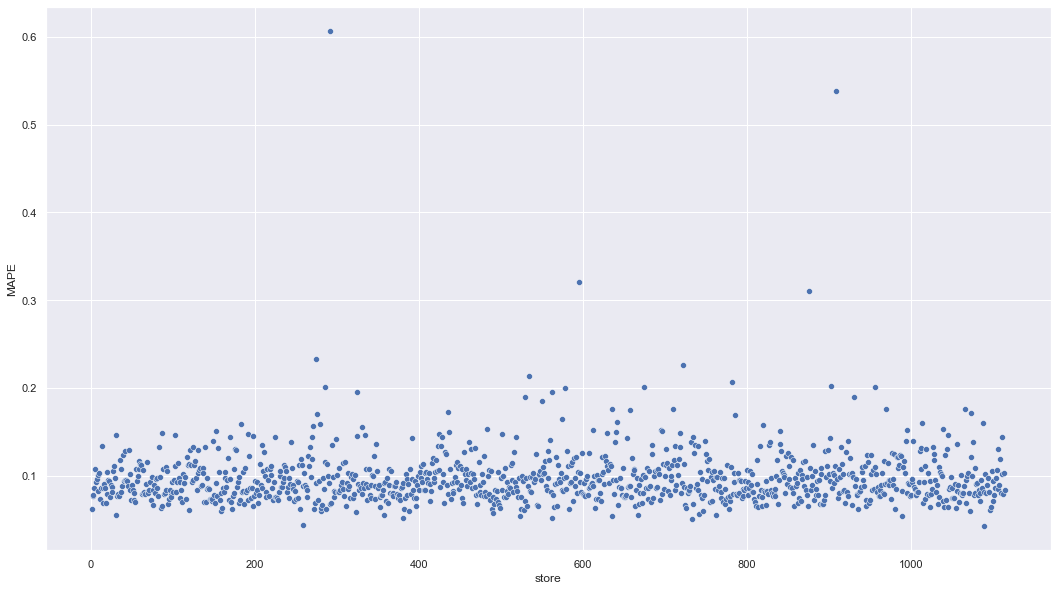

In [167]:
sns.scatterplot(data=df92, x='store', y='MAPE')

## 9.2 Total Performance

In [171]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$274,200,960.00"
1,worst_scenario,"R$273,453,773.10"
2,best_scenario,"R$274,948,139.99"


## 9.3 Machine Learning Performance

In [172]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

C:\Users\romul\AppData\Local\Temp/ipykernel_18544/1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\romul\AppData\Local\Temp/ipykernel_18544/1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


In [ ]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])
